In [1]:
import pickle
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate
import json

Using TensorFlow backend.


책 소개의 최대 길이 :2738
책 소개의 평균 길이 :98.09151630811937
책 소개 길이의 제3사분위수:123.25


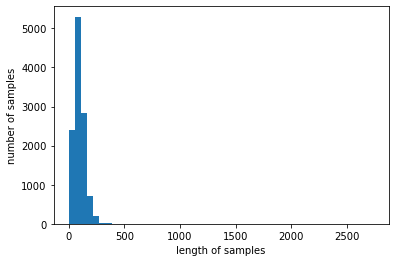

In [18]:
print('책 소개의 최대 길이 :{}'.format(max(len(l) for l in corpus)))
print('책 소개의 평균 길이 :{}'.format(sum(map(len, corpus))/len(corpus)))
print('책 소개 길이의 제3사분위수:{}'.format(pd.DataFrame([len(l) for l in corpus])[0].quantile(0.75)) )
plt.hist([len(s) for s in corpus], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

-------------------------
# CNN 다중분류

In [4]:
# 데이터 읽어오기
train_file = "./데이터/합본.csv"
data = pd.read_csv(train_file,encoding='cp949')
features = data['content'].tolist()
labels = data['label'].tolist()

# 단어 인덱스 시퀀스 벡터
corpus = [preprocessing.text.text_to_word_sequence(text) for text in features]

tokenizer = preprocessing.text.Tokenizer(num_words=30000)
# tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
word_index = tokenizer.word_index
MAX_SEQ_LEN = 300   # 단어 시퀀스 벡터 크기
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# 학습용, 검증용, 테스트용 데이터셋 생성 
# 학습셋:검증셋:테스트셋 = 7:2:1
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, labels))
ds = ds.shuffle(len(features))
train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size= int(len(padded_seqs) * 0.1)
train_ds = ds.take(train_size).batch(20)
val_ds = ds.skip(train_size).take(val_size).batch(20)
test_ds = ds.skip(train_size + val_size).take(test_size).batch(20)

In [6]:
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 8
VOCAB_SIZE = 36556  # 전체 단어 수

# CNN 모델 정의
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

# 3, 4, 5- gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(7, name='logits')(dropout_hidden)
predictions = Dense(7, activation=tf.nn.softmax)(logits)

# 모델 생성
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 학습 실행하기 
hist = model.fit(train_ds,  validation_data=val_ds,epochs=EPOCH, verbose=1)

Train for 404 steps, validate for 116 steps
Epoch 1/8
404/404 [==============================] - 27s 66ms/step - loss: 1.6348 - accuracy: 0.3642 - val_loss: 1.0130 - val_accuracy: 0.7076
Epoch 2/8
404/404 [==============================] - 25s 61ms/step - loss: 0.9520 - accuracy: 0.6982 - val_loss: 0.5892 - val_accuracy: 0.8295
Epoch 3/8
404/404 [==============================] - 25s 61ms/step - loss: 0.6736 - accuracy: 0.7811 - val_loss: 0.3874 - val_accuracy: 0.8946
Epoch 4/8
404/404 [==============================] - 25s 61ms/step - loss: 0.4995 - accuracy: 0.8417 - val_loss: 0.2711 - val_accuracy: 0.9180
Epoch 5/8
404/404 [==============================] - 25s 61ms/step - loss: 0.4181 - accuracy: 0.8757 - val_loss: 0.2222 - val_accuracy: 0.9297
Epoch 6/8
404/404 [==============================] - 25s 63ms/step - loss: 0.3466 - accuracy: 0.8945 - val_loss: 0.1917 - val_accuracy: 0.9397
Epoch 7/8
404/404 [==============================] - 25s 62ms/step - loss: 0.2952 - accuracy: 0.91

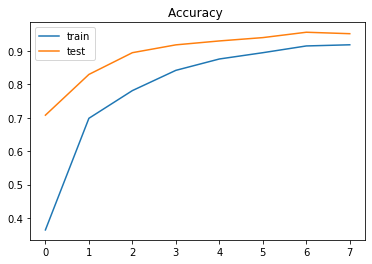

In [7]:
# 학습 상태를 그래프로 그리기 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy ')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

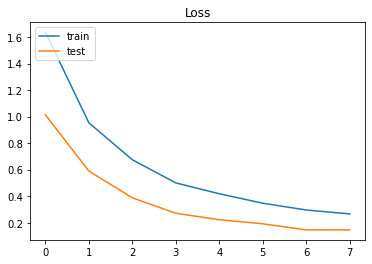

In [8]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
score = model.evaluate(test_ds, verbose=0)
print('accuray: ', score[1])

accuray:  0.9539931


In [8]:
# # 테스트하기 
# test_file = "./데이터/추가_test.csv"
# data = pd.read_csv(test_file,encoding='cp949')
# features = data['content'].tolist()
# labels = data['label'].tolist()

# corpus = [preprocessing.text.text_to_word_sequence(text) for text in features]

# sequences = tokenizer.texts_to_sequences(corpus)
# MAX_SEQ_LEN = 1400   # 단어 시퀀스 벡터 크기
# padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# ds = tf.data.Dataset.from_tensor_slices((padded_seqs, labels))
# ds = ds.shuffle(len(features))
# test_ds = ds.take(2307).batch(20)

--------------------------------
# CNN 모델 저장하고 로드하기

In [10]:
model_json = model.to_json()
with open("./모델/CNN_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("./모델/CNN_model.h5")


In [2]:
from tensorflow.compat.v2.keras.models import model_from_json

# model.json 파일 열기
json_file = open("./모델/CNN_model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 

# json파일로부터 model 로드하기
loaded_model = model_from_json(loaded_model_json)

# 로드한 model에 weight 로드하기
loaded_model.load_weights("./모델/CNN_model.h5")

 
# 모델 컴파일
loaded_model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])


# 모델 evaluation
# test_loss, test_acc = loaded_model.evaluate(test_X, test_y)
# print("Accuracy : %.2f%%" % (test_acc*100))


In [6]:
# tokenizer 정보 json으로 저장하기.
json_string = tokenizer.to_json()
import json
with open('./모델/token', 'w', encoding='utf-8') as make_file:
    json.dump(json_string, make_file, indent="\t")
    

In [7]:
# tokenizer 가져오기
with open('./모델/token', 'r') as f:
    json_data = json.load(f)

In [8]:
# t에 tokenizer 할당.
t = keras.preprocessing.text.tokenizer_from_json(json_data)

----------------------------
# 책 카테고리 분류하기! 

In [9]:
# 밑의 텍스트를 예측하는방법
from konlpy.tag import Okt
okt = Okt()

text = '13층을 더한 만큼 더욱 풍성해진 이야기!『130층 나무 집』은 각종 상을 휩쓸며 독자들의 사랑을 받은《13층 나무 집》시리즈의 최신작으로, 나무집은 어느새 ‘130층’까지 높아졌다. 글을 쓰는 앤디와 그림을 그리는 테리는 104층 나무 집에 13층을 더 올려 ‘130층 나무 집’을 짓고 더 흥미진진한 이야기로 돌아왔다. 13층씩 커지는 짜릿한 상상으로 아이들에게 재미를 선사한다. \
비상! ‘미확인 비행 눈알’이 나타났다! 나무 집에는 비눗방울 발사기, 시간 낭비 방, 다리가 엄청 길어지는 ‘롱 다리’ 방 들이 새로 생긴다. 그런데 짜증나는 파리 때문에 나무 집에 불이 난 것도 모자라, 나무 집이 통째로 미확인 비행 눈알에게 납치당한다. 앤디와 테리, 질의 운명은?북소믈리에 한마디!\
아무리 좋은 교훈이라도 잔소리처럼 느껴지기 쉽지만, 이 책은 교훈마저도 유쾌하고 전달하는 매력이 있다. 집 밖으로 나가 본 적은 없지만 화재를 피해 높은 건물 꼭대기에서 뛰어내린 테리, 엄격한 규율과 규칙을 강요하는 부모님 곁을 떠나 스스로의 삶을 찾아 나선 앤디, 부모님을 잃고 혼자가 되어서도 자신의 운명을 개척한 질. 늘 사이좋게 지내는 건 아니지만, 어렵고 힘들거나 외로울 때마다 진심으로 서로를 챙기는 세 사람 모습은 유쾌한 이야기만큼이나 가슴 찡한 감동을 전한다.'


In [10]:
word_s = okt.pos(text,norm=True ,stem=True)
result= ''
for n, h in word_s:
    if not (h in ['Noun', 'Verb ', 'Adjective']): continue #
    if len(n) == 1 : continue
    result = result + ' ' + n

In [11]:
corpus= preprocessing.text.text_to_word_sequence(result)
sequences = t.texts_to_sequences([corpus])


In [12]:
MAX_SEQ_LEN = 300   # 단어 시퀀스 벡터 크기
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [13]:
predict = loaded_model.predict(padded_seqs)
if predict.argmax() == 0 :
    print("이 책의 카테고리는 '경제/경영' 입니다")
elif predict.argmax() == 1:
    print("이 책의 카테고리는 '사회/정치' 입니다")
elif predict.argmax() == 2:
    print("이 책의 카테고리는 '시/소설' 입니다")
elif predict.argmax() == 3:
    print("이 책의 카테고리는 '어린이' 입니다")
elif predict.argmax() == 4:
    print("이 책의 카테고리는 '역사' 입니다")
elif predict.argmax() == 5:
    print("이 책의 카테고리는 '인문' 입니다")
elif predict.argmax() == 6:
    print("이 책의 카테고리는 '과학' 입니다")

이 책의 카테고리는 '어린이' 입니다
